# Collision Cross Section

Collision cross sections (CCS) are an important parameter that characterizes the ion mobility behavior of molecules in the gas phase. CCS values can provide complementary information to the mass-to-charge ratio (m/z), which is used typically used for molecule identification. The values are often predicted with ab initio means to increase confidence in identification. To predict CCS values, we require a geometry and ion type as input. ISiCLE takes these input and can sequentially generate adducts, conformers, DFT optimized geometries to obtain Boltzmann-weighted CCS values.

## Example Collision Cross Section Simulation
For an example CCS calculation, we load mol file containing dimethylglycine, which instantiates and ISiCLE Geometry object

In [ ]:
import isicle

geom = isicle.load('dimethylglycine.mol')
geom = geom.initial_optimize(embed=True)

### Adduct Generation
To generate adducts, we ionize the molecule with H+ using the `explicit` method. ... # Need Jess's description.
We specify the ion in the ion_list and the atom types to be ionized in element_list.

Multiple ionizations by monoatomic ions is possible by repeating the ionize function on an adduct geometry object. At this time, polyatomic ions are not supported. 

In [ ]:
# ionize Os and Ns
adducts = geom.ionize(method = 'explicit',
                      ion_list = ['H+'],
                      element_list = ['O', 'N'])


The ionize function returns an ISiCLE adduct object which contains the history, the original ISiCLE geometry, its RDKit Mol object, a list of ISiCLE geometry objects for each adduct, and the basename. Each adducts' ISiCLE geometry objects contains its RDKit Mol object, the ion type, adduct ID, overall charge.

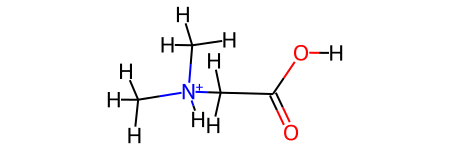

In [11]:
adducts = isicle.load('ccs_adducts.joblib')
adducts.adducts[0].mol

Here we can see that the first adduct has the nitrogen protonated, the second adduct has the =O protonated and the third has the -OH protonated. Next we generate conformers for each adduct.

### Conformational Ensembles
We use xtb's Conformer Rotamer Ensemble Sampling Tool, CREST to predict conformational ensembles. CREST is already a simple to use standalone command line tool, here we have created a Python function to call upon some tools CREST has made available followed by data parsed out from CREST output.

For example, here we generate conformers using a 3 kcal/mol energy window using the GFF forcefield.

In [ ]:
conformers = {}

for add in adducts.adducts:
    try:
        conformer = add.md(forcefield='gff',
                           ewin = 3,
                           task = 'conformer',
                           charge = add.charge,
                           processes = 4)
    except RuntimeError:
        continue

    # Each iteration of the md function instantiates a new ISiCLE XTBWrapper object. 
    # We collect them here in a dictionary.
    conformers[f"{add.basename}_{add.ion}_{add.adductID}"] = conformer

The output `conformers` is saved in `ccs_conformers.joblib`. Each ISiCLE XTBWrapper object contains the history, the unparsed contents of the output file, parsed timing information and a list of conformers found by CREST that have been converted into ISiCLE XYZGeometry objects. 

In [12]:
conformers = isicle.load('ccs_conformers.joblib')
conformers

{'dimethylglycine_H+_1': <isicle.md.XTBWrapper at 0x107bd0790>,
 'dimethylglycine_H+_2': <isicle.md.XTBWrapper at 0x1b5a5a730>,
 'dimethylglycine_H+_3': <isicle.md.XTBWrapper at 0x1b5a59160>}

In [13]:
conformers['dimethylglycine_H+_1'].get_structures()

[<isicle.geometry.XYZGeometry object at 0x1b5a5a4f0>, <isicle.geometry.XYZGeometry object at 0x1b5a5a520>]

### Density Functional Theory Calculations

We now calculate DFT single point energies for each conformer using open-source quantum chemical software, NWChem. The `dft` function generates the NWChem input file using the ISiCLE Geometry object and specifications for the DFT calculations. Specifications are customizable to any functional or basis set available in NWChem, but defaults are set to B3LYP and 6-31g*, respectively.

Here we calculate the perform geometry optimizations and single point energies for each conformer using the hybrid functional, B3LYP, and split valence, double zeta basis set, 3-21g*.

In [ ]:
dfts = {}

for adduct in conformers:
    
    c = conformers[adduct]
    # Instantiate a list to fill for each adduct
    conf_dft = []
    
    for geom in c.geom:
        try:
            dft = geom.dft(tasks=['optimize', 'energy'],
                              functional='B3LYP',
                              basis_set='3-21g*',
                              ao_basis='cartesian',
                              charge=c.charge,
                              gas=True,
                              max_iter=150,
                              mem_global=1600,
                              mem_heap=600,
                              mem_stack=1000,
                              scratch_dir='/tmp',
                              processes=4,
                              command='nwchem')

            conf_dft.append(dft)

        except RuntimeError:
            continue
    dfts[adduct] = conf_dft


`dfts` is a dictionary which contains an ISiCLE NWChemWrapper object for each DFT calculation. An NWChemWrapper object contains the optimized geometry, as well as parsed information from the NWChem output file, including electronic energy, Mulliken charges, timing information and structural connectivity. Results from the above script is saved in `ccs_dft.joblib` and can be viewed below.

In [19]:
dfts = isicle.load('ccs_dft.joblib')
dfts

{'dimethylglycine_H+_1': [<isicle.qm.NWChemWrapper at 0x1b40479d0>,
 'dimethylglycine_H+_2': [<isicle.qm.NWChemWrapper at 0x1b5a64940>,
 'dimethylglycine_H+_3': [<isicle.qm.NWChemWrapper at 0x1b5a70850>,
  <isicle.qm.NWChemWrapper at 0x1b57bcd90>]}

### Collision Cross Section Calculations

Next, we calculate the collision cross section for each of the optimized geometries produced from the DFT step using using a refactored version of MOBCAL for trajectory based mobility calculations. This version is included in the with installation of ISiCLE and improves upon the original verion's computational efficiency by two orders of magnitude. (Not currently supported on Mac).

We conduct the calculation in nitrogen gas at room temperature using the Lennard-Jones potential.

In [ ]:
for adduct in dfts:
   
    ccs_list = []

    for dft in dfts[adduct]: 
        try:
            mw = isicle.mobility.calculate_ccs(dft.geom, lennard_jones='default',
                                               i2=5013489,
                                               buffer_gas='nitrogen',
                                               buffer_gas_mass=28.014,
                                               temp=300,
                                               ipr=1000,
                                               itn=10,
                                               inp=48,
                                               imp=1024,
                                               processes=20,
                                               command='mobcal_shm')
            ccs_list.append(mw)

        except RuntimeError:
            continue

    ccs[adduct] = ccs_list


In [15]:
ccs = isicle.load('ccs_mobility.joblib')
ccs

{'dimethylglycine_H+_1': [<isicle.mobility.MobcalWrapper at 0x1b5a59fa0>,
 'dimethylglycine_H+_2': [<isicle.mobility.MobcalWrapper at 0x1a30ea310>,
 'dimethylglycine_H+_3': [<isicle.mobility.MobcalWrapper at 0x1a2e94a30>,
  <isicle.mobility.MobcalWrapper at 0x1b57bcb80>]}

### Boltzmann Averaging CCS Values
To obtain our Boltzmann weighted CCS values, we Boltzmann average across the different conformers by their DFT energies. This is accomplished using the `conformers` module. 

In [20]:
boltzmann = {}
import numpy as np

dft_energies = []
ccs_values = []

for adduct in ccs:
    for dft in dfts[adduct]:
        dft_energies.append(dft.energy)
    for ccs_v in ccs[adduct]:
        ccs_values.append(ccs_v.ccs['mean'])
    

res = isicle.conformers.boltzmann(ccs_values, dft_energies)
print(res)

mean    113.355158
std       0.042272
n        11.000000
Name: 0, dtype: float64


Finally, we calibrate the values by linear regression variables we obtained from our previous study. 

In [21]:
m = 0.8419640859610955
b = 35.15260461418354

ccs_mean = (res['mean'] * m) + b
ccs_std = res['std'] * m
print(ccs_mean, ccs_std)

130.59357623003885 0.03559141573268931


Our final CCS value for dimethylglycine is 130.6 $\r{A}^2$, predicting the experiemental value of 123.9 $\r{A}^2$ with 5.4% error.